In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from scipy.stats import entropy

In [2]:
# Load the data
df_pbs = pd.read_csv('../pbs_c/cmake-build-debug/pbsBlocks.csv')
df_cmp = pd.read_csv('../pbs_c/cmake-build-debug/comparison.csv')

In [3]:
df_pbs.describe()

,Block Number,Proposer ID,Builder ID,Winning Bid Value,Winning Block Value,Reward,Builder ID 1 Bid,Builder ID 2 Bid,Builder ID 3 Bid,Builder ID 4 Bid,...,Builder ID 1 Block Value,Builder ID 2 Block Value,Builder ID 3 Block Value,Builder ID 4 Block Value,Builder ID 5 Block Value,Builder ID 10 Block Value,Builder ID 30 Block Value,Builder ID 50 Block Value,Builder ID 70 Block Value,Builder ID 90 Block Value
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,250.500000,28.604000,33.510000,582.733684,611.379215,374.795213,150.112000,161.067000,131.382000,172.42700,...,466.532812,489.480390,481.431897,488.332912,497.248664,518.673719,592.64306,578.850439,544.239009,566.410580
std,144.481833,32.301361,32.606322,161.440833,164.154131,282.675036,235.338603,242.817148,216.800662,245.73688,...,184.662831,172.895555,173.506121,176.965048,177.652400,152.156146,164.69825,167.851846,145.094794,156.754235
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,125.750000,3.000000,4.000000,520.246750,545.918500,70.691000,0.000000,0.000000,0.000000,0.00000,...,355.075250,389.037500,362.126000,374.806000,400.469500,449.850250,516.65925,490.582250,471.163500,486.385250
50%,250.500000,5.000000,30.000000,616.250000,648.404000,447.144500,0.000000,0.000000,0.000000,0.00000,...,480.244000,506.363000,492.799000,509.429500,520.525500,530.578500,618.71550,594.949500,563.217500,581.634500
75%,375.250000,50.000000,70.000000,684.280250,716.893250,635.318250,339.000000,339.000000,338.500000,339.50000,...,604.647750,617.812000,618.872750,624.219500,623.373500,608.124250,699.26150,691.857500,646.321000,660.840500
max,500.000000,90.000000,90.000000,898.765000,923.971000,898.765000,755.000000,797.000000,735.500000,762.00000,...,890.271000,860.114000,864.385000,861.271000,842.062000,947.869000,920.77000,889.433000,914.031000,984.527000


In [4]:
def get_builder_type(id):
    if 1 <= id <= 9:
        return 'Normal Proposer Builder'
    elif 10 <= id <= 999:
        return 'MEV Proposer Builder'
    else:
        return 'Unknown Builder'

def adjust_builder_id(id):
    if(get_builder_type(id) == 'MEV Proposer Builder'):
        return int(int(id) / 20 + 1)
    else:
        return id

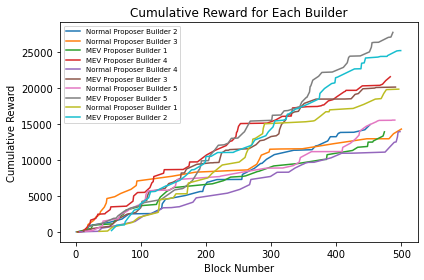

In [5]:
builder_ids = df_pbs['Builder ID'].unique()
fig, axs = plt.subplots()
for builder_id in builder_ids:
    builder_df_pbs = df_pbs[df_pbs['Builder ID'] == builder_id]
    cumulative_rewards = np.cumsum([reward for reward, id in zip(df_pbs['Reward'], df_pbs['Builder ID']) if id == builder_id])
    axs.plot(builder_df_pbs['Block Number'].values, cumulative_rewards, label=f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}')

axs.set_title('Cumulative Reward for Each Builder')
axs.set_xlabel('Block Number')
axs.set_ylabel('Cumulative Reward')
axs.legend(loc='best',prop={'size': 7})
plt.tight_layout()
plt.show()

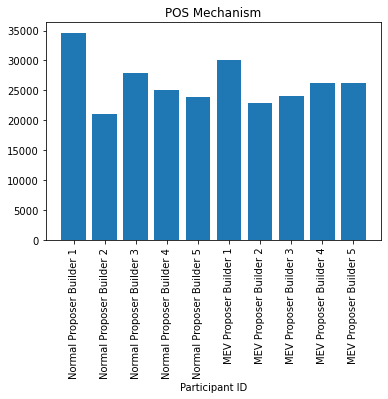

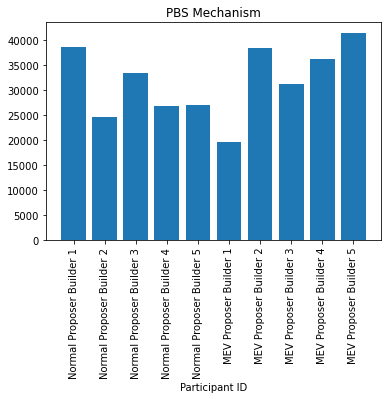

In [6]:
total_rewards_pos = []
total_rewards_pbs = []
builder_ids = np.sort(df_pbs['Builder ID'].unique())

for builder_id in builder_ids:
    cumulative_rewards_pbs = ([reward for reward, id, b_id in zip(df_pbs['Reward'], df_pbs['Builder ID'],df_pbs['Proposer ID']) if id == builder_id & id != b_id]+
                             [bid for bid, id in zip(df_pbs['Winning Bid Value'], df_pbs['Proposer ID']) if id == builder_id])
    total_rewards_pbs.append(sum(cumulative_rewards_pbs))

    cumulative_rewards_pos = [reward for reward, id in zip(df_cmp['POS Block Value'], df_cmp['POS Builder ID']) if id == builder_id]
    total_rewards_pos.append(sum(cumulative_rewards_pos))


builder_labels = [f'{get_builder_type(builder_id)} {adjust_builder_id(builder_id)}' for builder_id in builder_ids]
plt.bar(builder_labels, total_rewards_pos)
plt.title('POS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()

plt.bar(builder_labels, total_rewards_pbs)
plt.title('PBS Mechanism')
plt.xlabel('Participant ID')
plt.xticks(rotation=90) 
plt.show()



In [7]:
def gini(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [8]:
#this is for homogenous builders, 5 extra nodes, 10000 blocks. 
gini_pbs = gini(np.array(total_rewards_pbs))
gini_pos = gini(np.array(total_rewards_pos))

print(f'Gini coefficient for PBS rewards: {gini_pbs}')
print(f'Gini coefficient for POS rewards: {gini_pos}')

Gini coefficient for PBS rewards: 0.12071155291651353
Gini coefficient for POS rewards: 0.07636385282430878


In [9]:
# Herfindahl-Hirschman Index (HHI) 
def hhi(x):
    """Compute Herfindahl-Hirschman Index of array of values"""
    return (x**2).sum() / (x.sum())**2

hhi_pos = hhi(np.array(total_rewards_pos))
hhi_pbs = hhi(np.array(total_rewards_pbs))

print(f"HHI for PBS: {hhi_pbs}")
print(f"HHI for POS: {hhi_pos}")

HHI for PBS: 0.10451966934696647
HHI for POS: 0.10200637426021364


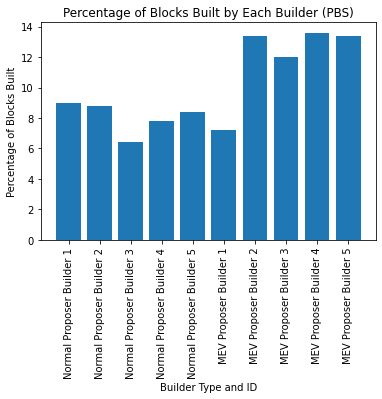

In [10]:
block_counts = [len(df_pbs[df_pbs['Builder ID'] == builder_id]) for builder_id in builder_ids]
block_percentages = [count / len(df_pbs) * 100 for count in block_counts]

plt.bar(builder_labels, block_percentages)
plt.title('Percentage of Blocks Built by Each Builder (PBS)')
plt.xlabel('Builder Type and ID')
plt.ylabel('Percentage of Blocks Built')
# Rotate the x-axis labels
plt.xticks(rotation=90) 
plt.show()
